# Topic Modeling

In [2]:
import os
import sys

# adding classes folder to system path
sys.path.insert(0, os.path.abspath('..') + '/src')

import copy
import logging
import operator
import warnings
import pandas as pd
import numpy as np
import pyLDAvis.gensim

from pprint import pprint
from gensim.test.utils import datapath

from data_loader import DataLoader
from data_utils import get_time_bins
from pre_processing import PreProcessing
from topic_modeling_gensim import TopicModeling

logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)
warnings.filterwarnings("ignore", category=DeprecationWarning)

doc_topic_path = os.path.abspath('..') + "/data/doc_top_dist.xlsx"

### (optional step) Finding the number of topics: Topic coherence
Now that we have cleaned tweets, we need to find the best number of topics for LDA topic modeling. Run the following cell to see the coherence score for different values of k, number of topics. 

Running the following cell may take a few minutes depending on how large the corpus is. We use the `LdaMulticore` to use multiple CPU cores to expedite the process. Also, if you want to use `Mallet`, simply set the `use_mallet=True` when calling the `TopicModeling` class.

Number of unique tokens: 386
Number of documents: 1000
2: -12.539549968151492
3: -12.19056916843293
4: -12.321659853158966
5: -12.061985800356755
6: -12.465140431459508
7: -12.820053219418483
8: -12.968600256160034
9: -13.43846209221126
10: -13.638967434654154
11: -14.274061237714461
12: -13.913649604459442
13: -14.509584325463656
14: -14.893072149967216
15: -14.662298811527611
16: -14.641911582419805
17: -15.072564007743862
18: -14.900961658564476
19: -14.707703966053176
20: -14.693694278693041
21: -14.711728739000776
22: -14.731440925869196
23: -15.01047255067967
24: -15.067117560876996
25: -15.192096564266452
26: -15.217658735487364
27: -15.374262471119502
28: -15.098070960987688
29: -15.435839384079554


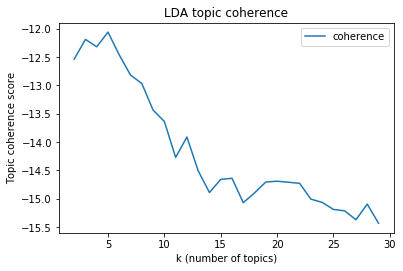

In [3]:
TopicModeling(cpu_count=3).find_topics_count()

## MALLET LDA

In [3]:
# creating dictionary and corpus
dictionary, corpus = TopicModeling(use_mallet=True, cpu_count=3, n_count=10000000).create_corpus()

Number of unique tokens: 90058
Number of documents: 1904678


In [4]:
# creating the LDA model
train_model_flag = True  # True, if want to create a new model, False, if loading the existing model
n_cpu = 8
k = 100
iterations = 200

if train_model_flag:
    coherence, lda = TopicModeling(use_mallet=True, cpu_count=n_cpu).learn_lda_model(corpus, dictionary, k, iterations)

    # Save model to disk
    model_file = datapath("mallet.model")
    lda.save(model_file)
else:
    # Load the pretrained model from disk
    lda = LdaModel.load(temp_file)

100: -5.3435351978564505


In [5]:
# Show Topics
pprint(lda.show_topics(num_words=10, num_topics=-1, formatted=False))

[(0,
  [('زندان', 0.05251424439091123),
   ('سیاسی', 0.0432145110846004),
   ('زلزله', 0.03487745448013155),
   ('زندانیان', 0.03293367664196257),
   ('خطر', 0.027226708060229476),
   ('سیل', 0.026264031358387493),
   ('زندانی', 0.024283404651248487),
   ('مبتلا', 0.022814056001068617),
   ('آزاد', 0.021335495133646243),
   ('جان', 0.018756074305744278)]),
 (1,
  [('زنگ', 0.04790065579343849),
   ('مامانم', 0.03834557540729872),
   ('بابام', 0.033934850097966415),
   ('مامان', 0.026061750154330654),
   ('حرف', 0.024509496926807012),
   ('بابا', 0.023865334204145904),
   ('میگفت', 0.023163017902355667),
   ('میزنه', 0.019870630653198895),
   ('دوستم', 0.018488364810821934),
   ('دیروز', 0.01554937238868063)]),
 (2,
  [('کرونا', 0.2455253896430367),
   ('دعا', 0.04507792860734037),
   ('مردم', 0.026787330316742082),
   ('زود', 0.013660130718954248),
   ('براش', 0.012850678733031674),
   ('سلامتی', 0.01277526395173454),
   ('تقصیر', 0.012217194570135747),
   ('عجب', 0.012176973353443941),

### Document-level topic distribution
Every document is a distribution/mixture of topics in the LDA model. In this part, we get the largest association value among topics associated with a document as the dominant topic of the document. Then, we do this for all documents in the corpus. In this way, we get an understanding of the topic distribution over the entire corpus.

#### 1. reading all raw docs from LDA corpus

In [5]:
print("doc topic: {}".format(lda.fdoctopics()))
print("mallet-formatted corpus: {}".format(lda.fcorpusmallet()))
print("text corpus: {}".format(lda.fcorpustxt()))
print("word weights: {}".format(lda.fwordweights()))

# loading docs
all_docs = pd.read_csv(lda.fcorpustxt(), header=None)

doc topic: /var/folders/ng/zjcgjmb938l9r82v8gppkrl40000gp/T/8cc511_doctopics.txt
mallet-formatted corpus: /var/folders/ng/zjcgjmb938l9r82v8gppkrl40000gp/T/8cc511_corpus.mallet
text corpus: /var/folders/ng/zjcgjmb938l9r82v8gppkrl40000gp/T/8cc511_corpus.txt
word weights: /var/folders/ng/zjcgjmb938l9r82v8gppkrl40000gp/T/8cc511_wordweights.txt


#### 2. finding dominant LDA topic for documents 

In [6]:
df_col = ["doc", "topic", "dist"]
df = pd.DataFrame(columns=df_col)

# loading docs * topics matrix
docs_topics = lda.load_document_topics()

idx = 0
for topics in docs_topics:
    doc_topics = pd.DataFrame(topics)
    topic_id = doc_topics[1].idxmax()
    topic_dist = doc_topics.iloc[topic_id][1]
    
    # less efficient
    # df = df.append({"doc": all_docs.iloc[idx][0], "topic": topic_id, "dist": topic_dist}, ignore_index=True)
    
    # more efficient
    df = pd.concat([df, pd.DataFrame(data={"doc": [all_docs.iloc[idx][0]], "topic": [topic_id], "dist": [topic_dist]})], ignore_index=True)
    idx += 1
    if idx % 50000 == 0:
        print("check point: {}".format(idx))

# saving data frame into file
df.to_excel(doc_topic_path)

check point: 50000
check point: 100000
check point: 150000
check point: 200000
check point: 250000
check point: 300000
check point: 350000
check point: 400000
check point: 450000
check point: 500000


#### (optional) listing topics and dominant documents percentage

In [9]:
load_df = False

if load_df == True:
    df = pd.read_excel(doc_topic_path)

    counts_df = df.groupby(df["topic"]).size().reset_index(name='count')

    # sort topics in descending order of count
    counts_df = counts_df.sort_values(by=["count"], ascending=False)

    sum_vals = counts_df["count"].sum()
    counts_df["percentage"] = round((counts_df["count"] / sum_vals) * 100, 2)

In [11]:
counts_df

,topic,count,percentage
4,4,29388,5.54
27,27,26201,4.94
32,32,23777,4.48
20,20,23629,4.46
1,1,23555,4.44
28,28,20522,3.87
42,42,17081,3.22
25,25,16776,3.16
2,2,14401,2.72
24,24,13779,2.60


#### 3. listing most associated documents for top topics

In [10]:
# parameters
top_n_topics = 50  # number of top distributed topics in LDA model
top_n_doc = 40  # number of top associated documents with each top topic

# ====================================================================
# group topics by count
counts_df = df.groupby(df["topic"]).size().reset_index(name='count')

# sort topics in descending order of count
counts_df = counts_df.sort_values(by=["count"], ascending=False)

# getting IDs of top topics
top_topics_ids = []
top_topics_dist = []

for i in range(top_n_topics):
    top_topics_ids.append(counts_df.iloc[i][0])
    top_topics_dist.append(counts_df.iloc[i][1])

# ====================================================================
# reading and concatenating original docs
df_docs_orig = DataLoader().load_tweets(n_count=10000000)
df_docs_orig = pd.DataFrame(df_docs_orig["text"].values.astype('U').tolist(), columns=["doc_orig"])

# features from df: ["doc", "topic", "dist"]
# feature from df_docs_orig: document pre stop word removal text
# df_all = concatenation of these two data frames.

df_all = pd.concat([df, df_docs_orig], axis=1)

# ====================================================================
# listing top documents for top topics
result = """"""
for topic_id in top_topics_ids:
    result += str(topic_id) + "\n"
    curr_df = copy.deepcopy(df_all.loc[df_all["topic"] == topic_id])
    curr_df = curr_df.sort_values(by=["dist"], ascending=False)[:top_n_doc]["doc_orig"]
    for doc in curr_df:
        result += doc + "\n"
    result += "\n"

with open(os.path.abspath('..') + "/data/top_topic_docs.txt", "w") as f:
    f.write(result)

In [18]:
df_dist_col = ["Topic ID", "Document Count"]
df_dist = pd.DataFrame(columns=df_dist_col)
for i in range(len(top_topics_ids)):
    df_dist = pd.concat([df_dist, pd.DataFrame(data={"Topic ID": [str(top_topics_ids[i])], "Document Count": [top_topics_dist[i]]})], ignore_index=True)

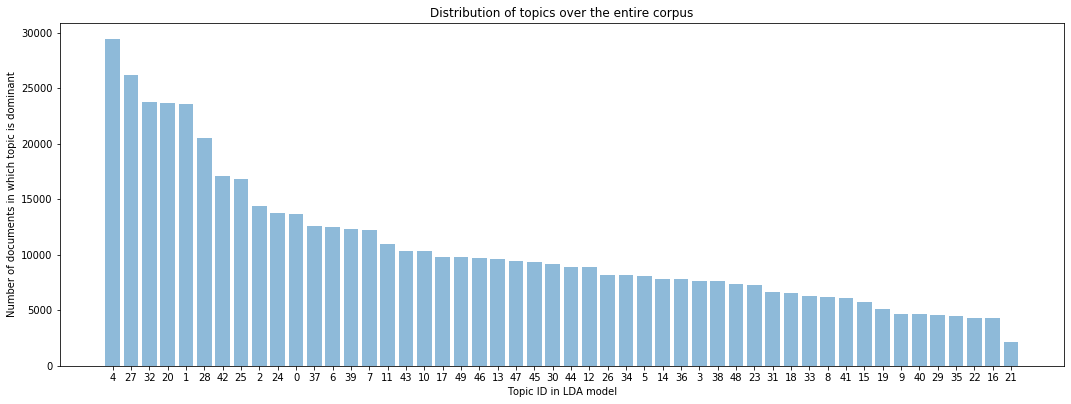

In [35]:
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

topic_ids = list(df_dist["Topic ID"])
y_pos = np.arange(len(objects))
values = list(df_dist["Document Count"])

f, ax = plt.subplots(figsize=(18,7)) 
plt.bar(y_pos, values, align='center', alpha=0.5)
plt.title("Distribution of topics over the entire corpus")
plt.xticks(y_pos, topic_ids)
plt.xlabel("Topic ID in LDA model")
plt.ylabel("Number of documents in which topic is dominant")
plt.gcf().subplots_adjust(bottom=0.2)
plt.savefig('topic_dist.pdf', format="pdf", pad_inches=2)
plt.show()

### Word-level topic distribution
Every word in the dictionary to a certain degree is associated with a topic. From another perspective, a topic is a distribution of words in the dictionary. Some words though may have zero association with a topic. 

In this part, for each topic, we count up the number of non-zero associated words with the topic to get a sense of topic distribution over words.

In [36]:
topics_words = lda.get_topics()
topic_count = {}

# finding the number of words associated with each topic
for i in range(len(topics_words)):
    topic_count[i] = np.count_nonzero(topics_words[i])

# sorting based on the frequency of associated words
sorted_dict = dict(sorted(topic_count.items(), key=operator.itemgetter(1),reverse=True))

for k, v in sorted_dict.items():
    print("topic {}: {}".format(k, v))

topic 4: 5630
topic 1: 5456
topic 20: 5237
topic 28: 5179
topic 42: 4572
topic 32: 4391
topic 17: 4389
topic 24: 4150
topic 43: 4041
topic 6: 4026
topic 7: 4004
topic 38: 3973
topic 37: 3780
topic 5: 3663
topic 44: 3318
topic 34: 3230
topic 12: 3207
topic 25: 3186
topic 2: 3099
topic 18: 3097
topic 36: 3081
topic 11: 3012
topic 15: 2986
topic 33: 2894
topic 14: 2826
topic 40: 2821
topic 0: 2771
topic 23: 2734
topic 26: 2656
topic 45: 2638
topic 35: 2553
topic 49: 2546
topic 31: 2403
topic 10: 2355
topic 48: 2309
topic 3: 2291
topic 30: 2290
topic 13: 2281
topic 46: 2239
topic 9: 2178
topic 41: 2092
topic 47: 2070
topic 22: 2034
topic 27: 2009
topic 16: 2008
topic 29: 1970
topic 39: 1966
topic 8: 1845
topic 19: 1066
topic 21: 1015


### [3.2] Gensim LDA

In [4]:
# creating the LDA model
n_cpu = 3
k = 50
coherence, lda = TopicModeling(cpu_count=3).learn_lda_model(corpus, dictionary, k)
pyLDAvis.enable_notebook()
p = pyLDAvis.gensim.prepare(lda, corpus, dictionary, sort_topics=True)

# saving the visualization of topics as html
pyLDAvis.save_html(p, 'lda.html')

50: -16.308288994851235


In [ ]:
p

In [5]:
topics = lda.print_topics(num_words=8)
for topic in topics:
    print(topic)

PreparedData(topic_coordinates=              x         y  topics  cluster      Freq
topic                                               
0     -0.051367 -0.061029       1        1  2.934463
34    -0.017920 -0.093933       2        1  2.920980
17    -0.077195 -0.143184       3        1  2.754239
40    -0.135540  0.053934       4        1  2.604252
23    -0.170136  0.023333       5        1  2.544087
33    -0.014647 -0.053866       6        1  2.516847
38     0.015099  0.057893       7        1  2.512262
5     -0.045303  0.040138       8        1  2.492951
35    -0.035831  0.059183       9        1  2.483133
42    -0.022178  0.155703      10        1  2.462330
1     -0.017136 -0.039000      11        1  2.407547
10    -0.080393 -0.093067      12        1  2.297013
39     0.122908  0.008649      13        1  2.231222
11     0.062904 -0.010360      14        1  2.200408
4     -0.049763 -0.063629      15        1  2.189290
46     0.019299 -0.034256      16        1  2.161188
15    -0.115770 -0.020971      17        1  2.155773
22    -0.087295  0.109143      18        1  2.138396
48    -0.008161 -0.055931      19        1  2.116049
3      0.045224  0.085074      20        1  2.114516
6      0.082327  0.113249      21        1  2.087899
36     0.007238  0.088099      22        1  2.067117
28    -0.047395  0.062452      23        1  2.053111
24     0.037427  0.054513      24        1  2.050689
45     0.024853 -0.012444      25        1  2.048063
13     0.135339  0.005993      26        1  2.017536
31     0.020032  0.111728      27        1  1.953341
32     0.075780  0.039297      28        1  1.939415
47    -0.074518 -0.053238      29        1  1.909495
21    -0.062820  0.014266      30        1  1.891549
2      0.093708  0.040722      31        1  1.890586
43    -0.049994  0.043149      32        1  1.876947
8      0.002422 -0.041390      33        1  1.850094
9      0.120810 -0.133553      34        1  1.848162
7     -0.067738  0.085988      35        1  1.745376
41     0.063257  0.029008      36        1  1.693064
19     0.065573  0.092820      37        1  1.672809
27     0.125370  0.066897      38        1  1.664406
25    -0.026390 -0.074596      39        1  1.650827
20     0.004445 -0.064813      40        1  1.618793
29    -0.001486  0.072659      41        1  1.579609
18     0.044247 -0.046997      42        1  1.570033
30    -0.057053  0.014222      43        1  1.517067
37    -0.013877 -0.042516      44        1  1.509489
49     0.049245 -0.107882      45        1  1.428829
44    -0.005828 -0.037012      46        1  1.408455
12     0.059356 -0.139760      47        1  1.364109
26    -0.009416 -0.049761      48        1  1.336676
16    -0.100236 -0.007581      49        1  1.327833
14     0.168526 -0.047343      50        1  1.191680, topic_info=         Term       Freq      Total Category  logprob  loglift
20      ایران  98.000000  98.000000  Default  30.0000  30.0000
21       مردم  65.000000  65.000000  Default  29.0000  29.0000
19    قرنطینه  43.000000  43.000000  Default  28.0000  28.0000
0        شیوع  54.000000  54.000000  Default  27.0000  27.0000
26   مبتلایان  34.000000  34.000000  Default  26.0000  26.0000
..        ...        ...        ...      ...      ...      ...
90      بحران   1.173562  16.585743  Topic50  -3.8359   1.7813
327       جان   1.173582  22.831350  Topic50  -3.8359   1.4617
21       مردم   1.173567  65.256050  Topic50  -3.8359   0.4115
182    آمریکا   1.173558  35.480572  Topic50  -3.8359   1.0209
19    قرنطینه   1.173558  43.980949  Topic50  -3.8359   0.8061

[2197 rows x 6 columns], token_table=      Topic      Freq  Term
term                       
136       4  0.102939    آب
136      17  0.102939    آب
136      22  0.411755    آب
136      28  0.102939    آب
136      31  0.102939    آب
...     ...       ...   ...
229      12  0.124562  گفته
229      15  0.124562  گفته
229      23  0.124562  گفته
229      24  0.124562  گفته
229      40  0.124562  گفته

[3337 rows x 3 columns], R=30, lambda_step

### [3.3] Topic modeling for time bins (ongoing...)

In [2]:
df = DataLoader().load_tweets(1000000, convert_time=True)

In [11]:
dfc = copy.deepcopy(df)

In [12]:
# 03-13-2020: start date
time_bins = get_time_bins("03-13-2020", 8, 5)

dfc['created_at'] = dfc['created_at'].dt.tz_localize(None)

for time_bin in time_bins:
    dfc_bin = dfc.loc[(dfc["created_at"] > time_bin[0]) & (dfc["created_at"] < time_bin[1])]
    # creating dictionary and corpus
    dictionary, corpus = TopicModeling(use_mallet=True, cpu_count=3, n_count=1000000).create_corpus()

In [ ]:
with open('../data/tweet_ids_v1.0.txt') as f:
    lines = f.readlines()